# Air Quality in Abuja in Nigeria (Using AR Model)

### Prepare Data

#### Import

In [1]:
# Import libraries here
import inspect
import time
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from datetime import datetime
from pytz import all_timezones
from glob import glob
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
warnings.simplefilter(action="ignore", category=FutureWarning)

source of DATA:https://africaopendata.org/dataset/sensorsafrica-airquality-archive-Abuja

In [2]:
# importing of CSV files

files = glob("C:/Users/NATHAN/Desktop/Data_DS_Projects/sensors.AFRICA Air Quality Archive Abuja/dataset/Abuja_Sensor_data_archive*.csv")
dataframes = []

for path in files:
    df = pd.read_csv(path, parse_dates=True)  # You can add other read_csv options as needed
    dataframes.append(df)
    
    
combined_df = pd.concat(dataframes, ignore_index=True)    

combined_df.to_csv("C:/Users/NATHAN/Desktop/Data_DS_Projects/sensors.AFRICA Air Quality Archive Abuja/dataset/Abuja_Sensor_data_archive_clean.csv")

In [5]:
# Create a wrangle function that will extract the PM2.5 
# readings from the site that has the most total readings in the Abuja 
# collection. Your function should do the following steps:

# Localize reading time stamps to the timezone for "Africa/Abuja".
# Remove all outlier PM2.5 readings that are above 100.
# Resample the data to provide the mean PM2.5 reading for each hour.
# Impute any missing values using the forward-will method.
# Return to y series.



# Creating a Wrangle function
def wrangle(filepath, resample_rule="1H"):
    df = pd.read_csv(filepath)

    # Separation of various columns
    df[["sensor_id","sensor_type","location","lat","lon","timestamp","value_type","value"]] = df["sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value"].str.split(";", expand=True)
    
    # Assign dtype to various columns
    df[["lat","lon","value"]] = df[["lat","lon","value"]].astype(float) 
    df[["location","sensor_id"]] = df[["location","sensor_id"]].astype(int)
    df[["sensor_type","value_type"]] = df[["sensor_type","value_type"]].astype(object)
    df["timestamp"]= pd.to_datetime(df["timestamp"])

    # Localize Timezone "Africa/Lagos"
    df["timestamp"]= df["timestamp"].dt.tz_convert("Africa/Lagos")
    
    # Drop multiple Columns 
    df.drop(columns=["sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value","sensor_id","location","lat","lon","sensor_type"], inplace=True)
   
    # Drop multiple rows in column 'value_type' wwhich is not "P2".
    mask = df["value_type"].isin(["P1", "P0", "humidity", "temperature"])
    df = df[~mask]
    
    # Drop column 'value_type'
    df.drop(columns=["value_type"], inplace=True)
    
    # Rename column 'value' to 'P2'
    df.rename(columns={"value":"P2"},inplace=True)
    
    # Drop multiple rows in column 'P2' which value is "0.0".
    mask_1 = df["P2"].isin([0.0])
    df = df[~mask_1]
    
    # Remove Outliers
    df = df[df["P2"]<100]
    
    # make the 'timestamp' index
    df = df.set_index("timestamp")
    
    # convert dataframe to series
    y = df["P2"].squeeze
    
    # Resample to 1hr window
    y = df["P2"].resample(resample_rule).mean().fillna(method="ffill")
    return y

In [6]:
# Combine your wrangle function, a list comprehension, and pd.concat to create a DataFrame df. It should contain all the properties from the CSVs in files.

y = wrangle(r"C:/Users/NATHAN/Desktop/Data_DS_Projects/sensors.AFRICA Air Quality Archive Abuja/dataset/Abuja_Sensor_data_archive_clean.csv")
print(y.info())
y.head()


<class 'pandas.core.series.Series'>
DatetimeIndex: 1232 entries, 2023-05-01 01:00:00+01:00 to 2023-06-21 08:00:00+01:00
Freq: H
Series name: P2
Non-Null Count  Dtype  
--------------  -----  
1232 non-null   float64
dtypes: float64(1)
memory usage: 19.2 KB
None


timestamp
2023-05-01 01:00:00+01:00    25.409174
2023-05-01 02:00:00+01:00    30.648198
2023-05-01 03:00:00+01:00    21.541892
2023-05-01 04:00:00+01:00    27.766667
2023-05-01 05:00:00+01:00    20.629907
Freq: H, Name: P2, dtype: float64

### Explore

Create a time series plot of the readings in y. Label your x-axis "Date" and your y-axis "PM2.5 Level". Use the title "Abuja PM2.5 Levels".

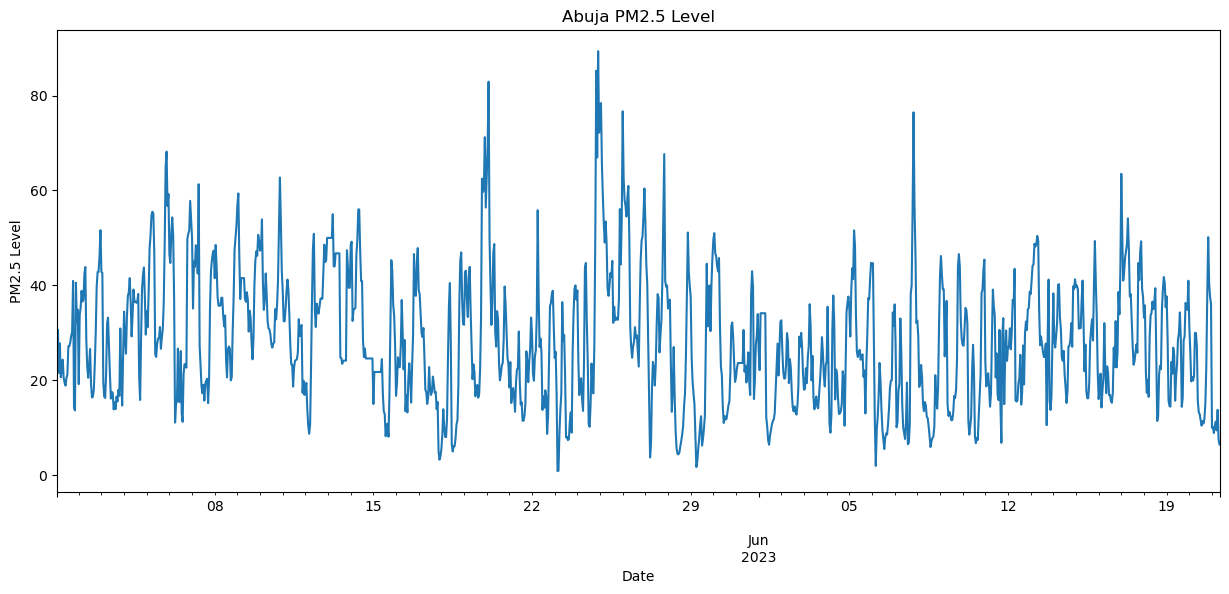

In [9]:
fig, ax = plt.subplots(figsize=(15, 6))
y.plot(xlabel="Date", ylabel="PM2.5 Level", title="Abuja PM2.5 Level");


 Plot the rolling average of the readings in `y`. Use a window size of `168` (the number of hours in a week). Label your x-axis `"Date"` and your y-axis `"PM2.5 Level"`. Use the title `"Abuja  PM2.5 Levels, 7-Day Rolling Average"`.

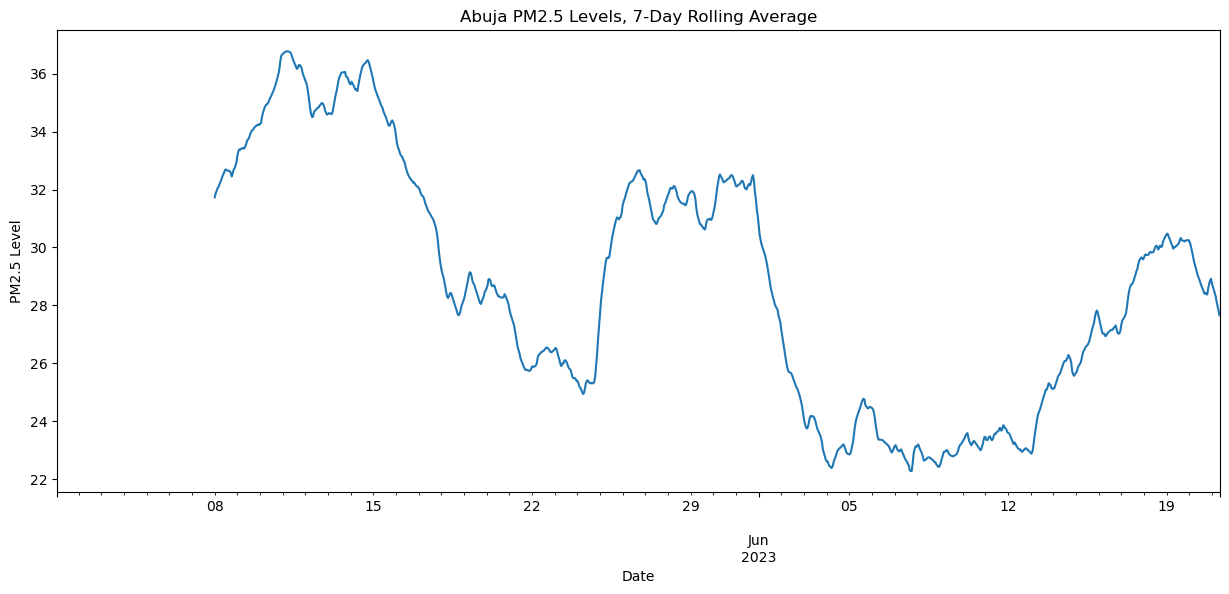

In [10]:
fig, ax = plt.subplots(figsize=(15, 6))
y.rolling(168).mean().plot(xlabel="Date",ylabel="PM2.5 Level",title="Abuja PM2.5 Levels, 7-Day Rolling Average");


Create an ACF plot for the data in `y`. Be sure to label the x-axis as `"Lag [hours]"` and the y-axis as `"Correlation Coefficient"`. Use the title `"Abuja PM2.5 Readings, ACF"`.

In [11]:
y.corr(y.shift(1))

0.8504397828465114

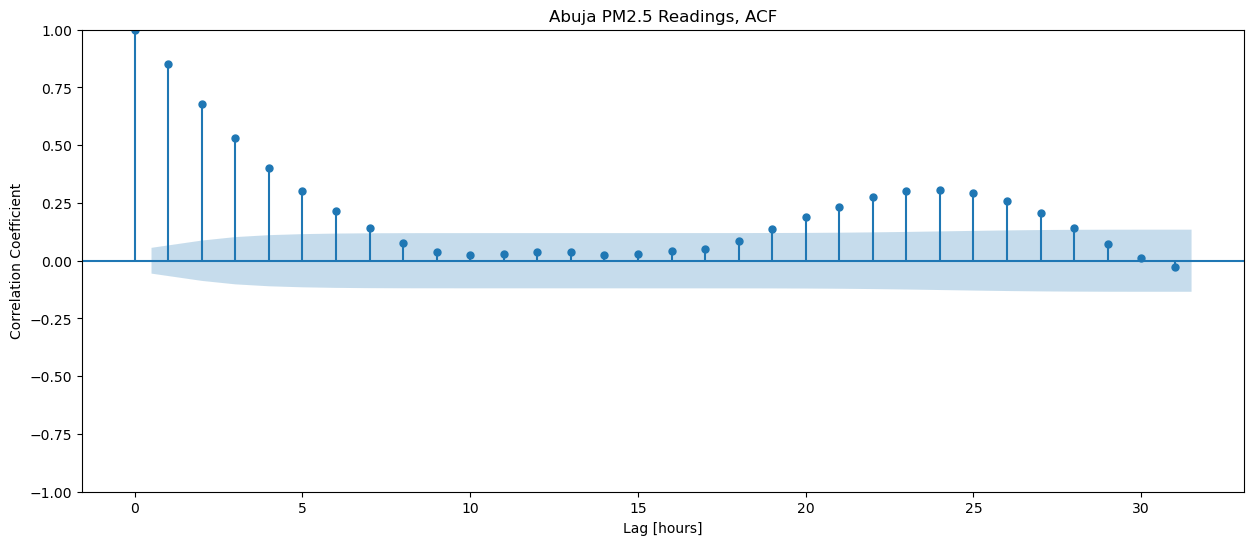

In [13]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Abuja PM2.5 Readings, ACF");


Create an PACF plot for the data in `y`. Be sure to label the x-axis as `"Lag [hours]"` and the y-axis as `"Correlation Coefficient"`. Use the title `"Abuja PM2.5 Readings, ACF"`.

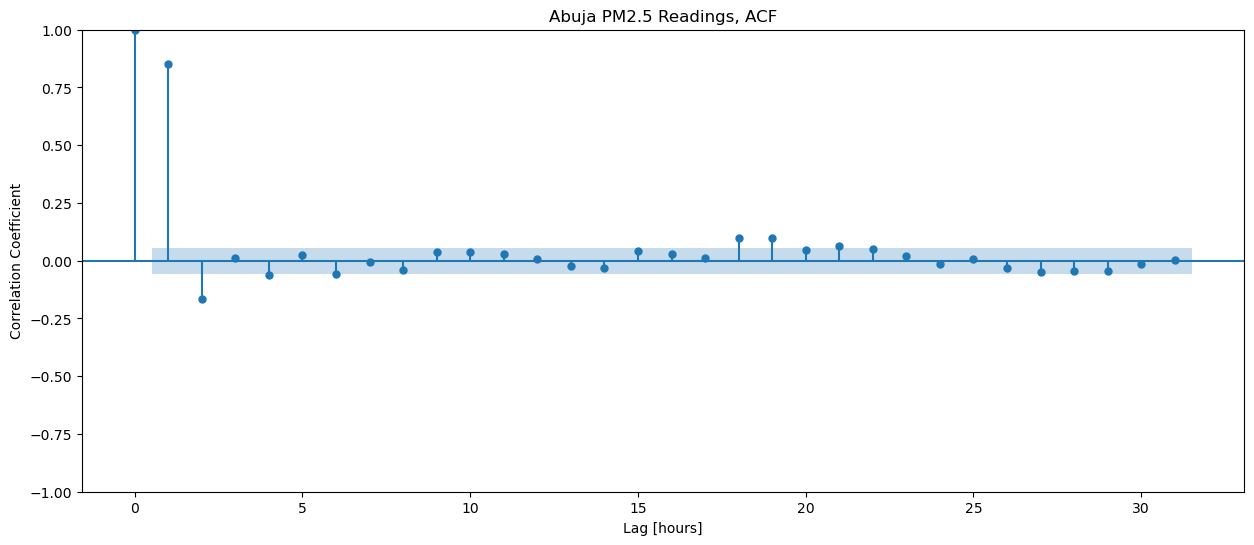

In [14]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Abuja PM2.5 Readings, ACF");


### Split
Split `y` into training and test sets. The first 90% of the data should be in your training set. The remaining 10% should be in the test set.

In [15]:
int(len(y)*0.90)

1108

In [24]:
cutoff_test = int(len(y)*0.90)
y_train = y.iloc[:cutoff_test]
y_test = y.iloc[cutoff_test:]
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1108,)
y_test shape: (124,)


## Build model

### Baseline

In [25]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", y_train_mean)
print("Baseline MAE:", mae_baseline)

Mean P2 Reading: 28.7078241664517
Baseline MAE: 11.197074336531145


### Iterate
You're going to use an AR model to predict PM2.5 readings, but which hyperparameter settings will give you the best performance? Use a `for` loop to train your AR model on using settings for `p` from 1 to 30. Each time you train a new model, calculate its mean absolute error and append the result to the list `maes`. Then store your results in the Series `mae_series`. 

In [27]:
p_params = range(1, 31)
maes = []
for p in p_params:
    model = AutoReg(y_train, lags=p).fit()
    y_pred = model.predict()
    training_mae = mean_absolute_error(y_train.iloc[p:],y_pred.iloc[p:])
    maes.append(training_mae)
    pass
mae_series = pd.Series(maes, name="mae", index=p_params)
mae_series.head()

1    5.235940
2    5.143640
3    5.136200
4    5.142190
5    5.135615
Name: mae, dtype: float64

Look through the results in `mae_series` and determine what value for `p` provides the best performance. Then build and train `final_model` using the best hyperparameter value.

Make sure that you build and train your model in one line of code, and that the data type of `best_model` is `statsmodels.tsa.ar_model.AutoRegResultsWrapper`. 

In [28]:
p_params = range(1, 31)
maes = []
for p in p_params:
    model = AutoReg(y_train, lags=p).fit()
    y_pred = model.predict()
    training_mae = mean_absolute_error(y_train.iloc[p:],y_pred.iloc[p:])
    maes.append(training_mae)
    pass
mae_series = pd.Series(maes, name="mae", index=p_params)
mae_series.head(30)

1     5.235940
2     5.143640
3     5.136200
4     5.142190
5     5.135615
6     5.147368
7     5.151260
8     5.155435
9     5.158800
10    5.167957
11    5.166985
12    5.171877
13    5.176020
14    5.181263
15    5.190141
16    5.183216
17    5.189482
18    5.178354
19    5.141424
20    5.141696
21    5.120476
22    5.109128
23    5.104950
24    5.094526
25    5.081331
26    5.085479
27    5.085762
28    5.082190
29    5.071968
30    5.071094
Name: mae, dtype: float64

In [29]:
best_p = 28
best_model = AutoReg(y_train, lags=28).fit()

Calculate the training residuals for `best_model` and assign the result to `y_train_resid`. **Note** that your name of your Series should be `"residuals"`.

In [30]:
y_train_resid = best_model.resid
y_train_resid.name = "residuals"
y_train_resid.head()

timestamp
2023-05-02 05:00:00+01:00     4.226440
2023-05-02 06:00:00+01:00     7.130540
2023-05-02 07:00:00+01:00     5.438610
2023-05-02 08:00:00+01:00   -11.992866
2023-05-02 09:00:00+01:00    -4.012715
Freq: H, Name: residuals, dtype: float64

Create a histogram of `y_train_resid`. Be sure to label the x-axis as `"Residuals"` and the y-axis as `"Frequency"`. Use the title `"Best Model, Training Residuals"`.

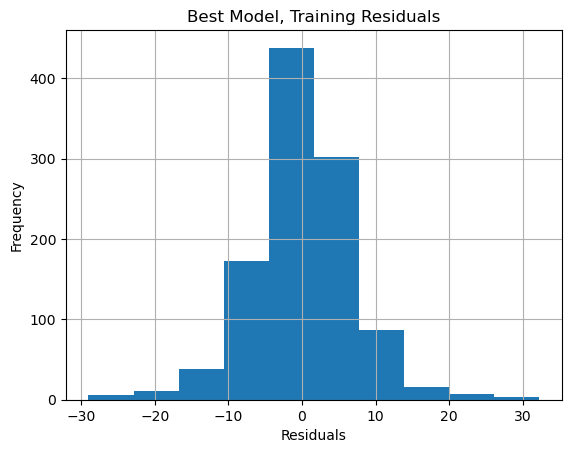

In [31]:
# Plot histogram of residuals
y_train_resid.hist()
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Best Model, Training Residuals");


Create an ACF plot for `y_train_resid`. Be sure to label the x-axis as `"Lag [hours]"` and y-axis as `"Correlation Coefficient"`. Use the title `"Abuja, Training Residuals ACF"`.

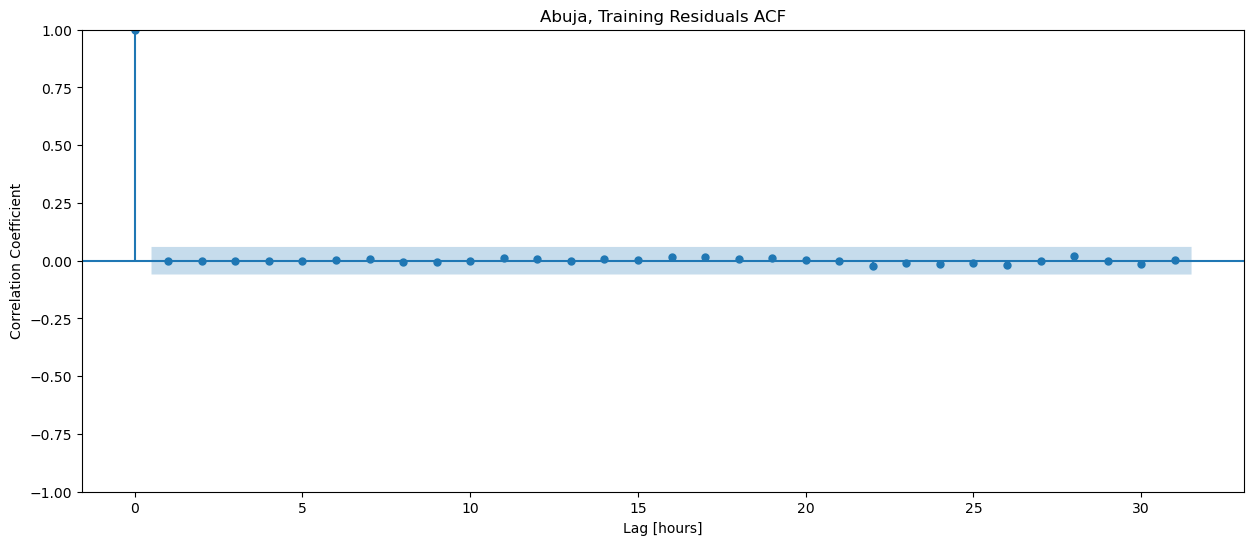

In [38]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid,  ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Abuja, Training Residuals ACF");

### Evaluate
Perform walk-forward validation for your model for the entire test set `y_test`. Store your model's predictions in the Series `y_pred_wfv`. Make sure the name of your Series is `"prediction"` and the name of your Series index is `"timestamp"`.

In [33]:
y_pred_wfv = pd.Series(dtype="float64")
history = y_train.copy()
for i in range(len(y_test)):
    model = AutoReg(history, lags=28).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])

y_pred_wfv.name = "prediction"
y_pred_wfv.index.name = "timestamp"
y_pred_wfv.head()

timestamp
2023-06-16 05:00:00+01:00    20.271787
2023-06-16 06:00:00+01:00    21.056900
2023-06-16 07:00:00+01:00    34.356448
2023-06-16 08:00:00+01:00    22.059877
2023-06-16 09:00:00+01:00    18.706559
Freq: H, Name: prediction, dtype: float64

## Communicate Result
Put the values for `y_test` and `y_pred_wfv` into the DataFrame `df_pred_test` (don't forget the index). Then plot `df_pred_test` using plotly express. Be sure to label the x-axis as `"Date"` and the y-axis as `"PM2.5 Level"`. Use the title `"Abuja, WFV Predictions"`.

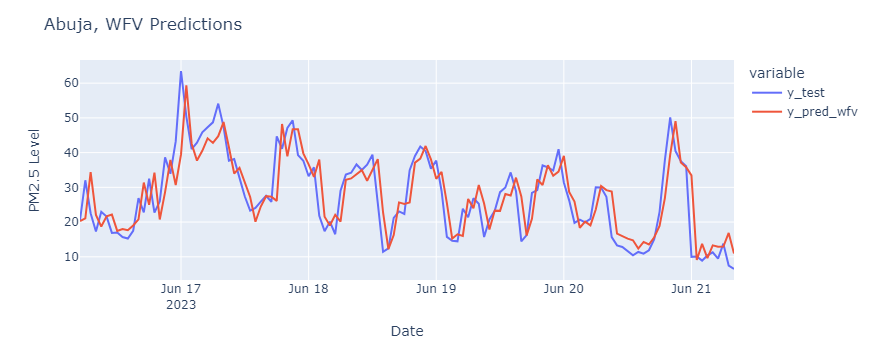

In [36]:
df_pred_test = pd.DataFrame(
    {
        "y_test": y_test, "y_pred_wfv":y_pred_wfv
    }
)
fig = px.line(df_pred_test, labels={"value":"PM2.5"})
fig.update_layout(
    title="Abuja, WFV Predictions",
    xaxis_title="Date",
    yaxis_title="PM2.5 Level",
)


fig.show()